In [1]:
import os
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import yt_dlp

def get_youtube_comments(video_url, max_comments=1000):
    """
    Tải comment từ video YouTube bằng yt-dlp
    """
    ydl_opts = {
        'extract_flat': True,
        'skip_download': True,
        'quiet': True,
        'no_warnings': True,
        'extractor_args': {'youtube:comments': {'max_comments': [str(max_comments)]}},
    }

    comments = []
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        try:
            info = ydl.extract_info(video_url, download=False)
            # yt-dlp không hỗ trợ comment trực tiếp → dùng cách khác
        except Exception as e:
            print("⚠️ yt-dlp không hỗ trợ lấy comment trực tiếp. Chuyển sang phương pháp thay thế.")
    
    # ⚠️ Thực tế: yt-dlp KHÔNG hỗ trợ comment. Ta dùng `youtube-comment-downloader` thay thế.

    return comments

In [5]:
from youtube_comment_downloader import YoutubeCommentDownloader, SORT_BY_RECENT
import json

def download_youtube_comments(video_url, output_file="comments.json", max_comments=1000):
    downloader = YoutubeCommentDownloader()
    comments = downloader.get_comments_from_url(video_url, sort_by=SORT_BY_RECENT)
    
    count = 0
    with open(output_file, 'w', encoding='utf-8') as f:
        for comment in comments:
            if count >= max_comments:
                break
            json.dump(comment, f, ensure_ascii=False)
            f.write('\n')
            count += 1
    print(f"✅ Đã lưu {count} comment vào {output_file}")
    return output_file

In [6]:
VIDEO_URL = "https://www.youtube.com/watch?v=JIVlYUUsPNE"
JSON_FILE = "youtube_comments.json"
CSV_FILE = "youtube_comments.csv"

# Tải comment (giới hạn 1000)
download_youtube_comments(VIDEO_URL, JSON_FILE, max_comments=1000)

# Chuyển JSON sang CSV
comments = []
with open(JSON_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            comments.append(json.loads(line))

df = pd.DataFrame(comments)
# Giữ lại cột quan trọng
df = df[['text', 'author', 'votes', 'time']]
df = df.rename(columns={"text": "comment_text"})

# Lưu CSV
df.to_csv(CSV_FILE, index=False, encoding='utf-8-sig')
print(f"✅ Đã lưu {len(df)} comment vào {CSV_FILE}")

✅ Đã lưu 1000 comment vào youtube_comments.json
✅ Đã lưu 1000 comment vào youtube_comments.csv


In [7]:
MODEL_PATH = "./phobert-emotion-final"

model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
id2label = model.config.id2label

print("✅ Model loaded. Labels:", list(id2label.values()))

✅ Model loaded. Labels: ['Accepting', 'Anger', 'Disappointed', 'Disgust', 'Enjoyment', 'Fear', 'Highly Negative', 'Hopeless', 'Hurt', 'Indifferent', 'Loneliness', 'Lonely', 'Neutral', 'Other', 'Sadness', 'Spam', 'Surprise']


In [8]:
def predict_emotion(text):
    if pd.isna(text) or not str(text).strip():
        return "Other", 0.0
    inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][pred_idx].item()
        emotion = id2label[pred_idx]
    return emotion, confidence

# Áp dụng cho toàn bộ
print("Đang dự đoán cảm xúc...")
tqdm.pandas()
df[['predicted_emotion', 'confidence']] = df['comment_text'].progress_apply(
    lambda x: pd.Series(predict_emotion(x))
)

# Lưu kết quả
OUTPUT_CSV = "youtube_comments_with_emotion.csv"
df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8-sig')
print(f"✅ Đã lưu kết quả vào: {OUTPUT_CSV}")

Đang dự đoán cảm xúc...


100%|██████████| 1000/1000 [00:48<00:00, 20.66it/s]

✅ Đã lưu kết quả vào: youtube_comments_with_emotion.csv


In [9]:
# 1. Phân bố cảm xúc
print("📊 Phân bố cảm xúc:")
print(df['predicted_emotion'].value_counts())

# 2. Hiển thị 10 comment có confidence cao nhất
print("\n💬 10 comment có độ tin cậy cao nhất:")
top_conf = df.nlargest(10, 'confidence')[['comment_text', 'predicted_emotion', 'confidence']]
for _, row in top_conf.iterrows():
    print(f"- [{row['predicted_emotion']}] ({row['confidence']:.3f}) {row['comment_text'][:100]}...")

📊 Phân bố cảm xúc:
predicted_emotion
Enjoyment     495
Other         219
Sadness       139
Disgust       130
Loneliness      9
Fear            7
Anger           1
Name: count, dtype: int64

💬 10 comment có độ tin cậy cao nhất:
- [Sadness] (0.918) Anh ơi. Shop toàn hết hàng à. Mua áo khoác mà vào mấy lần rồi toàn hết...
- [Enjoyment] (0.917) Vừa thấy Vũ là biết kết quả rồi… fan Vũ Trụ nha mọi người...
- [Sadness] (0.915) Nhìn mấy chú tội 😞...
- [Enjoyment] (0.914) Thấy team vui muốn hia nhập team ghê 😂😂...
- [Enjoyment] (0.913) Trời ơi trời Bé Tú ❤ dễ thương 😅...
- [Enjoyment] (0.913) mong ah ra thêm nhiều video hay hơn nx🥰...
- [Enjoyment] (0.912) coi được 2’ đầu thấy mặt ông vũ trụ thì bt luon kết quả😂😂...
- [Enjoyment] (0.912) Gala ô Vũ Trụ lại húp tiếp cái giải, ngon lành...
- [Enjoyment] (0.911) A vũ bỏ ảnh đó Tết lên rước ảnh cũng ngon lành ❤...
- [Enjoyment] (0.911) ước gì được a lâm mời đi thử thách xin tồn chúc a lâm nhiều sức khỏe và cả tem❤...


In [10]:
negative_emotions = ['Anger', 'Sadness', 'Disgust', 'Fear', 'Lonely', 'Hopeless', 'Hurt']
df_negative = df[df['predicted_emotion'].isin(negative_emotions)]

print(f"\n⚠️ Tìm thấy {len(df_negative)} comment tiêu cực.")
NEG_OUTPUT = "negative_comments_for_llm.csv"
df_negative.to_csv(NEG_OUTPUT, index=False, encoding='utf-8-sig')
print(f"✅ Đã lưu vào: {NEG_OUTPUT}")


⚠️ Tìm thấy 277 comment tiêu cực.
✅ Đã lưu vào: negative_comments_for_llm.csv


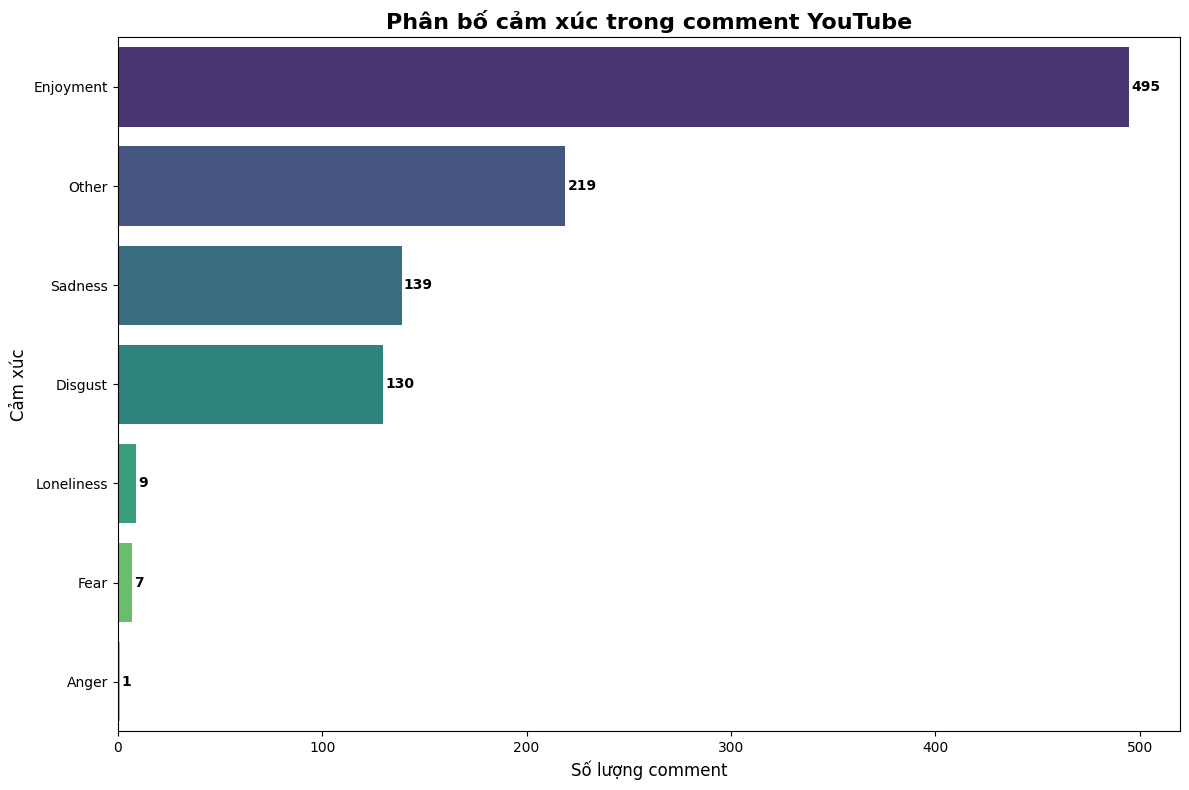

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tải lại dữ liệu (nếu cần)
df = pd.read_csv("youtube_comments_with_emotion.csv")

# Đếm số lượng theo emotion
emotion_counts = df['predicted_emotion'].value_counts()

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=emotion_counts.values, y=emotion_counts.index, palette="viridis")
plt.title("Phân bố cảm xúc trong comment YouTube", fontsize=16, weight='bold')
plt.xlabel("Số lượng comment", fontsize=12)
plt.ylabel("Cảm xúc", fontsize=12)

# Thêm số trên từng thanh
for i, v in enumerate(emotion_counts.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

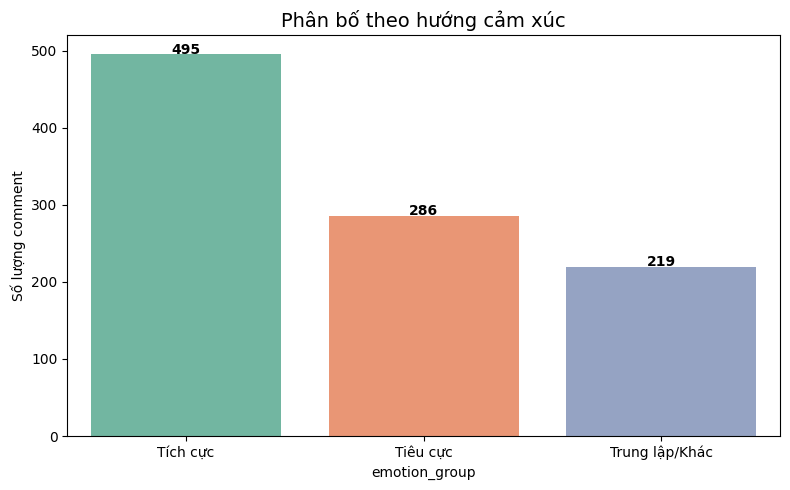

In [12]:
# Định nghĩa nhóm cảm xúc (bạn chỉnh theo hệ thống nhãn của mình)
positive = {'Enjoyment', 'Accepting', 'Hopeful', 'Surprise'}  # bạn bổ sung theo label thực tế
negative = {'Anger', 'Sadness', 'Disgust', 'Fear', 'Disappointed', 'Hopeless', 'Hurt', 'Lonely', 'Loneliness'}
neutral = {'Other', 'Neutral', 'Indifferent', 'Spam'}

def categorize_emotion(emotion):
    if emotion in positive:
        return 'Tích cực'
    elif emotion in negative:
        return 'Tiêu cực'
    else:
        return 'Trung lập/Khác'

df['emotion_group'] = df['predicted_emotion'].apply(categorize_emotion)

# Vẽ biểu đồ nhóm
group_counts = df['emotion_group'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=group_counts.index, y=group_counts.values, palette="Set2")
plt.title("Phân bố theo hướng cảm xúc", fontsize=14)
plt.ylabel("Số lượng comment")
for i, v in enumerate(group_counts.values):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()